<a href="https://colab.research.google.com/github/Krittika91/Deep-Learning-HW/blob/main/MIS285N_HW3_aw39578_kd29275_dg38354.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIS 285N Homework 3
**Due: Thursday, February 15, 11:59 pm**

Submit:

A pdf of your notebook with solutions.
A link to your colab notebook or also upload your .ipynb if not working on colab.

# Goals of this Homework: Fine Tuning and Transfer Learning

The goal of this colab notebook and homework is to get down the basics of Transfer learning, and harnessing the power of pre-trained notebooks. Along the way, we get experience with creating and labeling data sets, and a number of other Python tools.

Specifically, we do the following:

* In this colab notebook, we create our own labeled image data set, with calls to the Bing API. We use this to download images with user-specified labels, into train and test directories.

* We preprocess all the images and use the directory names as lables to create our training and testing data sets.

* Then we download a pre-trained convolutional neural network from Pytorch. There is wide selection here. These have been trained on ImageNet. See references below.

* Then we add a new last layer, and train. Note that the last layer we add has to have the right size, namely, the number of classes in our data.

* Things to play with: Choosing different pre-trained models; Fine tuning the entire network vs freezing and fine tuning only the last layer or layers; Possibly adding more of our own layers at the end. (See the last optional problem at the end).


Some references:

The bing image downloader package from here https://pypi.org/project/bing-image-downloader/


# The following will allow us to call the Bing Image Downloader

In [ ]:
!pip install bing-image-downloader

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import requests
from bing_image_downloader import downloader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

plt.ion()   # interactive mode


# Downloading the images we need

In [ ]:
# These are the functions we need for asking for query terms, number of images
# and the fraction of train/test split
def get_query_terms():
    """Ask the user for a list of query terms."""
    queries = input("Enter query terms separated by commas: ").split(',')
    return [query.strip() for query in queries]


def get_positive_integers():
    """Ask the user for a list of positive integers."""
    while True:
        numbers = input("Enter positive integers corresponding to each query, separated by commas: ").split(',')
        try:
            # Convert string inputs to integers
            numbers = [int(num.strip()) for num in numbers]

            # Check if all numbers are positive
            if all(num > 0 for num in numbers):
                return numbers
            else:
                print("All numbers must be positive. Please try again.")
        except ValueError:
            print("Invalid input. Please enter integers only.")


def get_train_test_proportion():
    """Ask the user for a number between 0 and 1 and ensure it is in that range."""
    while True:
        try:
            # Ask the user for a number and try to convert it to a float
            num = float(input("What fraction of the data should be training? For example, enter 0.75 for 75 percent: "))

            # Check if the number is between 0 and 1 (inclusive)
            if 0 <= num <= 1:
                return num
            else:
                print("The number must be between 0 and 1. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a valid number between 0 and 1.")

# Problem 0

Run the above code, to make your own data set. Choose terms that aren't already one of the 1000 classes in the Imagenet dataset.

I recommend starting small: 2 or 3 different terms, and maybe 100-200 images max from each.

In [ ]:
# Now we get the queries
queries = get_query_terms()
# And the number of each
numbers = get_positive_integers()
# And the fraction of training data
frac_train = get_train_test_proportion()
# Check if number of queries matches number of positive integers
if len(queries) != len(numbers):
  print("Number of queries and integers do not match!")

for query, n in zip(queries, numbers):
  n_tr = int(math.floor(n*frac_train))
  downloader.download(query, limit=n_tr, output_dir='dataset/train', adult_filter_off=True, force_replace=False,timeout=60, verbose=False)
  n_test = int(math.floor(n * (1-frac_train)))
  downloader.download(query, limit=n_test, output_dir='dataset/test', adult_filter_off=True, force_replace=False, timeout=60, verbose=False)


Enter query terms separated by commas: teacher, student, janitor
Enter positive integers corresponding to each query, separated by commas: 150, 150, 150
What fraction of the data should be training? For example, enter 0.75 for 75 percent: 0.75
[%] Downloading Images to /content/dataset/train/teacher
[!] Issue getting: http://ctboom.com/wp-content/uploads/ir.ashx_39.jpg
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: http://newcitymortgage.com/wp-content/uploads/2017/03/teacher.jpg
[!] Error:: Remote end closed connection without response
[!] Issue getting: http://www.treasury.tn.gov/portals/0/Images/Services/tn_web_teacher_liability_male_teacher.jpg
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: https://www.creativefabrica.com/wp-content/uploads/2022/04/28/Teacher-png-Teacher-Quote-png-Teacher-Graphics-29778702-1.jpg
[!] Error:: HTTP Error 403: Forbidden
[Error]Invalid image, not saving https://theartofpatriciaallinghamcarlson.files.wordpress.com/2014/02/art-teacher.

# Let's make sure we downloaded enough of each

In [ ]:
import os

def count_files_in_directory(directory, prefix=""):
    """
    Recursively counts the number of files in each directory and subdirectory.

    Args:
    - directory: The directory path to start counting from.
    - prefix: A string used for indentation to visualize the folder structure.
    """
    num_files = sum([len(files) for r, d, files in os.walk(directory)])
    print(f"{prefix}{os.path.basename(directory)}: {num_files} files")

    for subdir in next(os.walk(directory))[1]:  # List subdirectories of the current directory
        path = os.path.join(directory, subdir)  # Full path of the subdirectory
        count_files_in_directory(path, prefix + "  ")  # Recursively count in this subdirectory

# Path to the dataset directory
dataset_dir = './dataset'

# Start the recursive count
count_files_in_directory(dataset_dir)


dataset: 447 files
  train: 336 files
    student: 112 files
    teacher: 112 files
    janitor: 112 files
  test: 111 files
    student: 37 files
    teacher: 37 files
    janitor: 37 files


# Preprocessing the data

Now that we've downloaded the data we want, we do some basic preprocessing with functions from Torchvision.

For the training data, we normalize and also use some data augmentation.

For the validation set, we just normalize.

# Problem 1 (Nothing to turn in)
Read about this here: https://pytorch.org/vision/stable/transforms.html

# We made dataloaders out of our training and testing data

In [ ]:

# Data augmentation and normalization for training
# Just normalization for validation

# The directory that contains the data
data_dir = 'dataset'

# Now we apply the usual transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Problem 2
Write code that calls the dataloaders and displays some number of images, with their true labels.

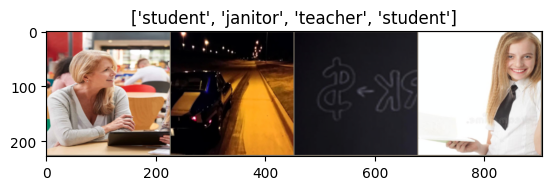

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
plt.show()

# Download a pre-trained model

We will now download a pretrained model that has been trained on Imagenet. I recomend starting with Resnet18. See here for other larger or smaller pre-trained modfels https://pytorch.org/vision/stable/models.html

In [ ]:
# Now we load a pre-trained model, and replace the last layer with a non-initialized linear layer.

# This command loads a pre-trained model
model_ft = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


# Problem 3

Redefine the last layer of your neural network (called model_ft) to be a linear (fully connected layer) whose input size is whatever the input size is of the the current last layer, and whose output size is the number of labels your new data set has.

You need to figure out how to do this. It's not too difficult. You need will use similar commands as you used in the last 2 homeworks in order to define a linear layer. The key will be to find out what the last layer is called, and also to find out what is its input size, so that you can properly define the size of the last fully connected (linear) layer.

In [ ]:
num_classes = 3  # Update with the actual number of classes in your dataset

# Get the number of features in the last layer
num_ftrs = model_ft.fc.in_features

# Define the new fully connected layer with the desired output size
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# Training

* We are going to fine-tune by training all the layers.

* We can also freeze the old layers, and only update the last layers that we added. (This is not implemented below.)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() # updates the learning rate

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Parameters of the optimization

# Problem 4 (Optional)
Explore choosing different learning rates or optimizers to see how things go.

In [ ]:
# We need to set the loss function, the optimizer, and the learning rate scheduler
criterion = nn.CrossEntropyLoss()
# though we're fine tuning, we're updating all parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# the scheduler decreases the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)  # Move model to the GPU if available

# Assuming train_model function trains your model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.0340 Acc: 0.5479
test Loss: 0.4405 Acc: 0.8378

Epoch 1/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.9102 Acc: 0.5838
test Loss: 0.3978 Acc: 0.8018

Epoch 2/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.9183 Acc: 0.6317
test Loss: 0.4431 Acc: 0.8198

Epoch 3/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.9601 Acc: 0.6796
test Loss: 1.0245 Acc: 0.7027

Epoch 4/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7674 Acc: 0.7186
test Loss: 0.2013 Acc: 0.9099

Epoch 5/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8531 Acc: 0.6198
test Loss: 0.2746 Acc: 0.8649

Epoch 6/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.8075 Acc: 0.6886
test Loss: 0.1573 Acc: 0.9369

Epoch 7/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5995 Acc: 0.7605
test Loss: 0.1273 Acc: 0.9459

Epoch 8/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4835 Acc: 0.8144
test Loss: 0.0980 Acc: 0.9640

Epoch 9/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4744 Acc: 0.8084
test Loss: 0.0922 Acc: 0.9730

Epoch 10/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4961 Acc: 0.7964
test Loss: 0.0888 Acc: 0.9550

Epoch 11/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4315 Acc: 0.8234
test Loss: 0.0734 Acc: 0.9910

Epoch 12/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4637 Acc: 0.8114
test Loss: 0.0658 Acc: 0.9820

Epoch 13/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4326 Acc: 0.8054
test Loss: 0.0611 Acc: 1.0000

Epoch 14/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4336 Acc: 0.8533
test Loss: 0.0601 Acc: 1.0000

Epoch 15/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4451 Acc: 0.8443
test Loss: 0.0543 Acc: 1.0000

Epoch 16/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4560 Acc: 0.8084
test Loss: 0.0605 Acc: 0.9910

Epoch 17/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4078 Acc: 0.8563
test Loss: 0.0522 Acc: 1.0000

Epoch 18/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4686 Acc: 0.8204
test Loss: 0.0542 Acc: 0.9910

Epoch 19/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4286 Acc: 0.8413
test Loss: 0.0669 Acc: 0.9910

Epoch 20/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3768 Acc: 0.8533
test Loss: 0.0589 Acc: 0.9910

Epoch 21/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4015 Acc: 0.8234
test Loss: 0.0679 Acc: 0.9910

Epoch 22/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4846 Acc: 0.8234
test Loss: 0.0589 Acc: 1.0000

Epoch 23/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4611 Acc: 0.7934
test Loss: 0.0564 Acc: 0.9910

Epoch 24/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3553 Acc: 0.8443
test Loss: 0.0528 Acc: 1.0000

Training complete in 3m 3s
Best test Acc: 1.000000


# Problem 5

Report your accuracy on the testing set. You should compute this explicitly by running all your testing examples through the model and checking them against their true labels.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU if available
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the testing set: {accuracy:.2%}")


Accuracy on the testing set: 100.00%


# Now let's visualize to see how well we did

# Problem 6

Print out images from the test set, reporting the predicted labels and the true labels.

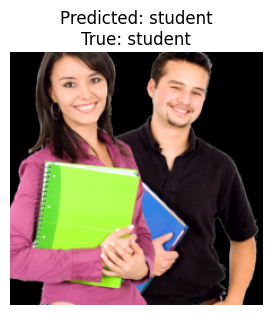

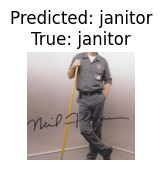

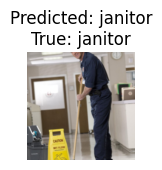

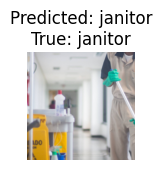

<Figure size 640x480 with 0 Axes>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to display images with labels
def imshow_with_labels(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Disable axes
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of testing data
inputs, labels = next(iter(dataloaders['test']))

# Move the data to the same device as the model
inputs = inputs.to(device)

# Perform a forward pass to obtain the predictions
outputs = model_ft(inputs)
_, predicted = torch.max(outputs, 1)

# Convert class indices to class names
predicted_class_names = [class_names[idx] for idx in predicted]
true_class_names = [class_names[idx] for idx in labels]

# Plot the images with predicted and true labels
plt.figure(figsize=(15, 5))
for i in range(len(inputs)):
    plt.subplot(1, len(inputs), i + 1)
    # Move the current input to CPU for visualization
    input_cpu = inputs[i].cpu()
    imshow_with_labels(input_cpu, title=f'Predicted: {predicted_class_names[i]}\nTrue: {true_class_names[i]}')

plt.tight_layout()
plt.show()


# Problem 7 (Optional)

Experiment with some/all of the following:

* Play with different pre-trained models
* Experiment with different pre-processing of the data (e.g., turn data augmentation on or off).
* Experiment with adding more/fewer layers, and/or layers of different size.
* Fine tune by training everything or only the last (new) layer -- this requires figuring out how to only update some of the layers.
* Try to reduce the number of images you use for training. How few can you use and still get good accuracy? Remember that you were all able to learn what a Goblin shark is with only one single example.